In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [2]:
df=pd.read_csv('star_classification.csv')
#feature selection
df = df.drop(['obj_ID','alpha','delta','run_ID','rerun_ID','cam_col','field_ID','spec_obj_ID','plate','MJD','fiber_ID'], axis='columns')

#cleaning the data
df = df[(df['u'] >= 0)]

print(df.describe())
print(df.head(5))

                  u             g             r             i             z  \
count  99999.000000  99999.000000  99999.000000  99999.000000  99999.000000   
mean      22.080679     20.631583     19.645777     19.084865     18.768988   
std        2.251068      2.037384      1.854763      1.757900      1.765982   
min       10.996230     10.498200      9.822070      9.469903      9.612333   
25%       20.352410     18.965240     18.135795     17.732280     17.460830   
50%       22.179140     21.099930     20.125310     19.405150     19.004600   
75%       23.687480     22.123775     21.044790     20.396510     19.921120   
max       32.781390     31.602240     29.571860     32.141470     29.383740   

           redshift  
count  99999.000000  
mean       0.576667  
std        0.730709  
min       -0.009971  
25%        0.054522  
50%        0.424176  
75%        0.704172  
max        7.011245  
          u         g         r         i         z   class  redshift
0  23.87882  22.2753

In [3]:
def mase_seasonal(y_true, y_pred, seasonality = 4):
    #absolute errors
    mae_abs = np.mean(np.abs(y_true - y_pred))

    #absolute errors with seasonal naivety
    mae_seasonal_naive = np.mean(np.abs(y_true[seasonality:] - y_true[:-seasonality]))

    # Avoid division by zero
    if mae_seasonal_naive == 0:
        return np.nan 

    return mae_abs / mae_seasonal_naive

# Galaxies

In [4]:
#turning the Class values into categorical data
df=df.rename(columns = {'class':'Class'})
df.Class = df.Class.astype('category')
cat_columns = df.select_dtypes(['category']).columns
cat_columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

#subset galaxies
df_galaxy = df[df['Class'] == 0]

# peculiar velocities with redshift < 0
df_galaxy_low = df_galaxy[(df_galaxy['redshift'] < 0)]

df_galaxy_high = df_galaxy[(df_galaxy['redshift'] >= 1.0)]

print(f"galaxies with peculiar velcities redshift < 0\n {df_galaxy_low.describe()}\n\n")
print(f"galaxies with peculiar velcities redshift < 0\n {df_galaxy_high.describe()}\n\n")
print(f"galaxies with peculiar velcities redshift < 0\n {df_galaxy.describe()}\n\n")

galaxies with peculiar velcities redshift < 0
                u          g          r          i          z  Class   redshift
count  42.000000  42.000000  42.000000  42.000000  42.000000   42.0  42.000000
mean   22.807958  21.408365  20.441285  20.356410  20.143177    0.0  -0.001592
std     1.640003   1.793601   1.675332   1.630806   1.595679    0.0   0.002469
min    18.881950  17.158470  15.932280  16.083770  15.971990    0.0  -0.009971
25%    22.096330  20.600735  19.327230  19.642073  19.185608    0.0  -0.002051
50%    22.802195  21.343335  20.769200  20.486075  20.386670    0.0  -0.000341
75%    23.635348  22.131397  21.856440  21.564982  21.567155    0.0  -0.000086
max    26.948550  27.532110  23.245410  23.558880  22.500530    0.0  -0.000005


galaxies with peculiar velcities redshift < 0
                 u           g           r           i           z  Class  \
count  893.000000  893.000000  893.000000  893.000000  893.000000  893.0   
mean    23.279331   22.663069   22.111730

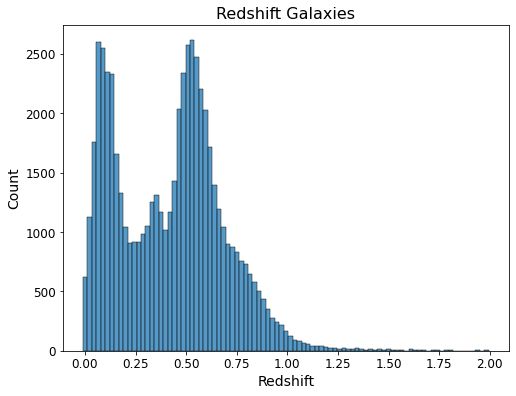

In [5]:
# Histogramm of redshift distribution in galaxies

plt.figure(figsize=(8, 6))

sns.histplot(data=df_galaxy, x='redshift', palette='Set2', kde=False)

plt.xlabel("Redshift", fontsize=14)  # X-axis label
plt.ylabel("Count", fontsize=14)  # Y-axis label
plt.title("Redshift Galaxies", fontsize=16)  # Title

plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)

plt.show()

In [6]:
#photometric redshift prediction on galaxies
# train test split
X = df_galaxy.drop('redshift',axis='columns')
y = np.array(df_galaxy['redshift'])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4, random_state = 42)

#array dimensions
y_train = y_train.transpose()
y_test = y_test.transpose()

rf_model = RandomForestRegressor(random_state = 42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
mase_value = mase_seasonal(y_test, y_pred)

print("MSE:", mse)
print(f"RMSE:", np.sqrt(mse))
print(f"MAE:", mean_absolute_error(y_test, y_pred))
print("MASE (Seasonal):", mase_value)
print(f"R2:", r2_score(y_test, y_pred))

MSE: 0.014421047094743148
RMSE: 0.12008766420720801
MAE: 0.05854354215492821
MASE (Seasonal): 0.1961106182510335
R2: 0.7940690661925186


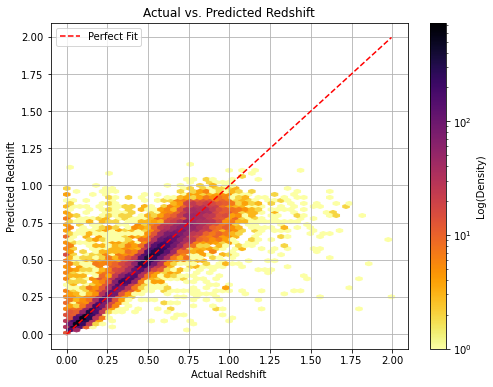

In [7]:
# 2D scatter plot
plt.figure(figsize=(8, 6))
hb = plt.hexbin(y_test, y_pred, gridsize=50, cmap='inferno_r', bins='log', mincnt=1)

# 1:1 Perfect Fit Line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect Fit')

# Labels and title
plt.xlabel("Actual Redshift")
plt.ylabel("Predicted Redshift")
plt.title("Actual vs. Predicted Redshift")
plt.colorbar(label='Log(Density)')  # Color bar indicating density
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

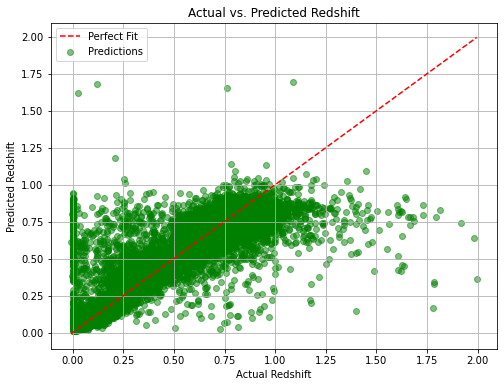

In [7]:
# Scatter plot of actual vs. predicted redshifts
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='green', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect Fit')  # 1:1 line

# Labels and title
plt.xlabel("Actual Redshift")
plt.ylabel("Predicted Redshift")
plt.title("Actual vs. Predicted Redshift")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Quasars

                  u             g             r             i             z  \
count  18961.000000  18961.000000  18961.000000  18961.000000  18961.000000   
mean      21.547619     20.926193     20.624089     20.431173     20.266732   
std        1.495879      1.163239      1.084237      1.080135      1.095076   
min       10.996230     13.662170     12.357630     12.637440     11.302470   
25%       20.637640     20.249730     20.006330     19.811070     19.644250   
50%       21.503240     21.056290     20.772720     20.582110     20.373970   
75%       22.286470     21.687770     21.413450     21.202280     21.001230   
max       32.781390     27.894820     27.397090     32.141470     28.790550   

         Class      redshift  
count  18961.0  18961.000000  
mean       1.0      1.719676  
std        0.0      0.913954  
min        1.0      0.000461  
25%        1.0      1.106605  
50%        1.0      1.617232  
75%        1.0      2.220279  
max        1.0      7.011245  


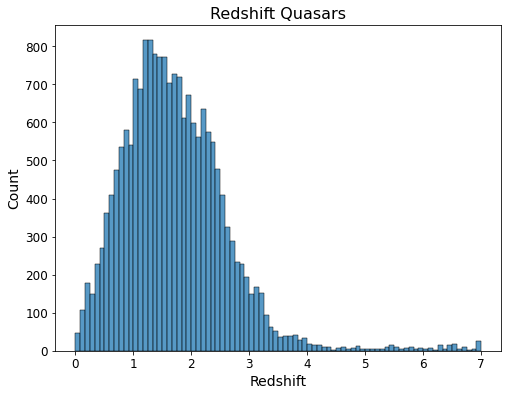

In [8]:
# extract quasars, plot redshift
df_qso = df[df['Class'] == 1]
print(df_qso.describe())

# Histogramm of redshift distribution in quasars

plt.figure(figsize=(8, 6))

sns.histplot(data=df_qso, x='redshift', palette='Set2', kde=False)

plt.xlabel("Redshift", fontsize=14)  # X-axis label
plt.ylabel("Count", fontsize=14)  # Y-axis label
plt.title("Redshift Quasars", fontsize=16)  # Title

plt.xticks(fontsize=12)  # Adjust tick label size
plt.yticks(fontsize=12)

plt.show()

In [9]:
df_qso_high =df_qso[(df_qso['redshift']>= 4)]

print(df_qso_high.describe())

                u           g           r           i           z  Class  \
count  321.000000  321.000000  321.000000  321.000000  321.000000  321.0   
mean    23.527102   22.253888   21.167577   20.578261   20.308108    1.0   
std      1.591313    1.400648    1.266712    1.146947    1.254645    0.0   
min     16.922270   15.752020   14.117790   15.094630   15.037360    1.0   
25%     22.539470   21.586060   20.509470   19.917730   19.514820    1.0   
50%     23.605020   22.107870   21.288070   20.542280   20.110330    1.0   
75%     24.625630   23.036480   21.816690   21.295080   21.035490    1.0   
max     27.235000   26.145600   25.221890   25.358540   23.666590    1.0   

         redshift  
count  321.000000  
mean     5.534142  
std      0.963366  
min      4.002810  
25%      4.649783  
50%      5.528454  
75%      6.449718  
max      7.011245  


In [10]:
# photometric redshift prediction on quasars
# train test split
X_qso = df_qso.drop('redshift',axis='columns')
y_qso = np.array(df_qso['redshift'])

X_qso_train, X_qso_test, y_qso_train, y_qso_test = train_test_split(X_qso,y_qso,test_size=0.2, random_state = 42)


y_qso_train = y_qso_train.transpose()
y_qso_test = y_qso_test.transpose()


rf_qso_model = RandomForestRegressor(random_state = 42)
rf_qso_model.fit(X_qso_train, y_qso_train)
y_qso_pred = rf_qso_model.predict(X_qso_test)


# Evaluate performance
mse1 = mean_squared_error(y_qso_test, y_qso_pred)
mase_value1 = mase_seasonal(y_qso_test, y_qso_pred)

print("MSE:", mse1)
print(f"RMSE:", np.sqrt(mse1))
print(f"MAE:", mean_absolute_error(y_qso_test, y_qso_pred))
print("MASE (Seasonal):", mase_value1)
print(f"R2:", r2_score(y_qso_test, y_qso_pred))

MSE: 0.5288528857637305
RMSE: 0.7272227208797388
MAE: 0.45580489768392857
MASE (Seasonal): 0.4829366585055811
R2: 0.32743707838272285


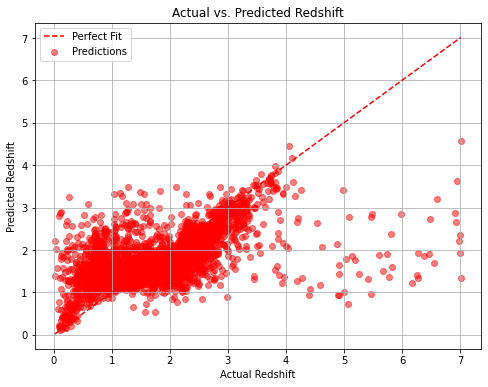

In [11]:
# Scatter plot of actual vs. predicted redshifts
plt.figure(figsize=(8, 6))
plt.scatter(y_qso_test, y_qso_pred, alpha=0.5, color='red', label='Predictions')
plt.plot([min(y_qso_test), max(y_qso_test)], [min(y_qso_test), max(y_qso_test)], linestyle='--', color='red', label='Perfect Fit')  # 1:1 line

# Labels and title
plt.xlabel("Actual Redshift")
plt.ylabel("Predicted Redshift")
plt.title("Actual vs. Predicted Redshift")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

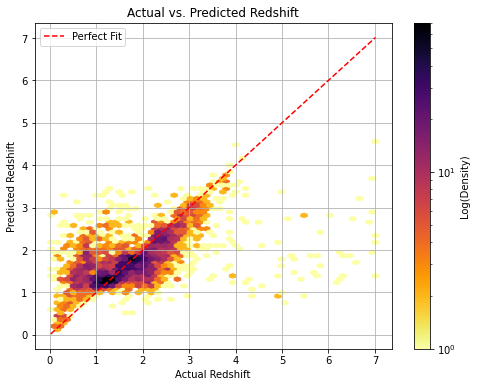

In [12]:
# 2D scatter plot
plt.figure(figsize=(8, 6))
hb = plt.hexbin(y_qso_test, y_qso_pred, gridsize=50, cmap='inferno_r', bins='log', mincnt=1)

# 1:1 Perfect Fit Line
plt.plot([min(y_qso_test), max(y_qso_test)], [min(y_qso_test), max(y_qso_test)], linestyle='--', color='red', label='Perfect Fit')

# Labels and title
plt.xlabel("Actual Redshift")
plt.ylabel("Predicted Redshift")
plt.title("Actual vs. Predicted Redshift")
plt.colorbar(label='Log(Density)')  # Color bar indicating density
plt.legend()
plt.grid(True)

# Show the plot
plt.show()